In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re
import keras

In [ ]:
def removeDuplicates(S): 
          
    n = len(S)  
      
    # We don't need to do anything for  
    # empty or single character string.  
    if (n < 2) : 
        return
          
    # j is used to store index is result  
    # string (or index of current distinct  
    # character)  
    j = 0
      
    # Traversing string  
    for i in range(n):  
          
        # If current character S[i]  
        # is different from S[j]  
        if (S[j] != S[i]): 
            j += 1
            S[j] = S[i]  
      
    # Putting string termination  
    # character.  
    j += 1
    S = S[:j] 
    return "".join(S) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/pcd/Train.csv')
testset=pd.read_csv('/content/drive/MyDrive/pcd/Test.csv')

In [ ]:
data.head()

,ID,text,label
0,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
1,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
2,U0TTYY8,ak slouma,1
3,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1
4,OSTX8NX,hhhhhhhh blidaa minik ba3d doussieet athika il...,1


In [ ]:
data["text"]=data['text'].apply(lambda x :removeDuplicates(list(x.rstrip())) )

In [ ]:
testset["text"]=testset['text'].apply(lambda x :removeDuplicates(list(x.rstrip())) )

In [ ]:
data['text'] = data['text'].apply(lambda x: x.lower())
testset['text'] = testset['text'].apply(lambda x: x.lower())
# removing special chars
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
testset['text'] = testset['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#
data.head()


,ID,text,label
0,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kresi,-1
1,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
2,U0TTYY8,ak slouma,1
3,68DX797,entom titmanou lina a7na 3id moubarik a7na cha...,-1
4,OSTX8NX,h blida minik ba3d dousiet athika ilkol 8nayit...,1


In [ ]:
testset.head()

,ID,text
0,2DDHQW9,barcha aindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9a7ba
2,ATNVUJX,saber w bara rabi m3ak 5ouya
3,Q9XYVOQ,cha3b ta7an tfouh
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchalah itch...


In [ ]:
data.label.value_counts()

 1    38239
-1    29295
 0     2466
Name: label, dtype: int64

In [ ]:
print(data[ data['label'] == 1].size)
print(data[ data['label'] == -1].size)
print(data[ data['label'] == 0].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('.','')
    row[0] = row[0].replace(",","")
    row[0] = row[0].replace(":","")
    row[0] = row[0].replace("\"","")
    row[0] = row[0].replace("!","")
    row[0] = row[0].replace("â€œ","")
    row[0] = row[0].replace("â€˜","")
    row[0] = row[0].replace("*","")
for idx,row in testset.iterrows():
    row[0] = row[0].replace('.','')
    row[0] = row[0].replace(",","")
    row[0] = row[0].replace(":","")
    row[0] = row[0].replace("\"","")
    row[0] = row[0].replace("!","")
    row[0] = row[0].replace("â€œ","")
    row[0] = row[0].replace("â€˜","")
    row[0] = row[0].replace("*","")   
data.head()

114717
87885
7398


,ID,text,label
0,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kresi,-1
1,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
2,U0TTYY8,ak slouma,1
3,68DX797,entom titmanou lina a7na 3id moubarik a7na cha...,-1
4,OSTX8NX,h blida minik ba3d dousiet athika ilkol 8nayit...,1


In [ ]:
data.label+=1

In [ ]:
data.label.value_counts()

2    38239
0    29295
1     2466
Name: label, dtype: int64

In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
X[:2]

array([[  0,   0,   0, ...,   0, 258,  25],
       [  0,   0,   0, ..., 119,   2,   6]], dtype=int32)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
Y = pd.get_dummies(data['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(56000, 782) (56000, 3)
(14000, 782) (14000, 3)


In [ ]:
embed_dim = 128
lstm_out = 192

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 782, 128)          256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 782, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 192)               246528    
_________________________________________________________________
dense (Dense)                (None, 3)                 579       
Total params: 503,107
Trainable params: 503,107
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import os
checkpoint_path = "/content/drive/MyDrive/pcd/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
batch_size = 128
history =model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, validation_split=0.1,callbacks=[cp_callback])

Epoch 1/3
394/394 [==============================] - 107s 261ms/step - loss: 0.7113 - accuracy: 0.6526 - f1_m: 0.5997 - precision_m: 0.6429 - recall_m: 0.5724 - val_loss: 0.5304 - val_accuracy: 0.7755 - val_f1_m: 0.7679 - val_precision_m: 0.8050 - val_recall_m: 0.7343

Epoch 00001: saving model to /content/drive/MyDrive/pcd/training_1/cp.ckpt
Epoch 2/3
394/394 [==============================] - 102s 259ms/step - loss: 0.5213 - accuracy: 0.7709 - f1_m: 0.7668 - precision_m: 0.7991 - recall_m: 0.7372 - val_loss: 0.5164 - val_accuracy: 0.7764 - val_f1_m: 0.7736 - val_precision_m: 0.7942 - val_recall_m: 0.7543

Epoch 00002: saving model to /content/drive/MyDrive/pcd/training_1/cp.ckpt
Epoch 3/3
394/394 [==============================] - 102s 259ms/step - loss: 0.4941 - accuracy: 0.7840 - f1_m: 0.7803 - precision_m: 0.8100 - recall_m: 0.7530 - val_loss: 0.5091 - val_accuracy: 0.7779 - val_f1_m: 0.7734 - val_precision_m: 0.8066 - val_recall_m: 0.7430

Epoch 00003: saving model to /content/dr

In [ ]:
Y_pred = model.predict_classes(X_test,batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("f1score: ", score[2])
print("percision: ", score[3])
print("recall: ", score[4])

438/438 [==============================] - 26s 59ms/step - loss: 0.5093 - accuracy: 0.7787 - f1_m: 0.7710 - precision_m: 0.8044 - recall_m: 0.7412
Test Score: 0.5092791318893433
Test Accuracy: 0.7787142992019653
f1score:  0.7710169553756714
percision:  0.804379403591156
recall:  0.7412242889404297


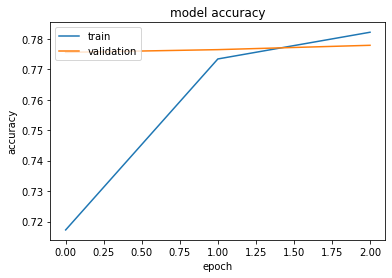

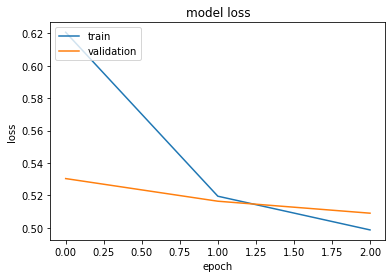

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [ ]:
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print("confusion matrix",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred))

confusion matrix [[4901   29  929]
 [ 273   56  136]
 [1704   27 5945]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      5859
           1       0.50      0.12      0.19       465
           2       0.85      0.77      0.81      7676

    accuracy                           0.78     14000
   macro avg       0.69      0.58      0.59     14000
weighted avg       0.78      0.78      0.77     14000



In [ ]:
def predict(text):
  #vectorizing the tweet by the pre-fitted tokenizer instance
  text = tokenizer.texts_to_sequences(text)
  #padding the tweet to have exactly the same shape as `embedding_2` input
  text = pad_sequences(text, maxlen=28, dtype='int32', value=0)
  sentiment = model.predict(text,batch_size=1,verbose = 2)[0]
  if(np.argmax(sentiment) == 0):
      print("negative")
  elif (np.argmax(sentiment) == 1):
      print("neutral")
  elif (np.argmax(sentiment) == 2):
      print("positive")

In [ ]:
def prepare_submission():


    test_data = testset['text']
    test_id = testset['ID']

    tokenizer.fit_on_texts(test_data)
    sequence = tokenizer.texts_to_sequences(test_data)
    test_final = pad_sequences(sequence, maxlen = max_features )
    result_final = model.predict(test_final)
    print(result_final)
    dataf = pd.DataFrame(data = {'id' : test_id ,'text': testset['text'], 'positive' : result_final[:,0] ,'neutral' : result_final[:,1] ,'negative' : result_final[:,2]  })
    dataf.to_csv('/content/drive/MyDrive/pcd/resultkerasLSTM.csv')

In [ ]:
prepare_submission()

[[0.79424584 0.00767358 0.19808058]
 [0.26700994 0.0878653  0.6451248 ]
 [0.32498267 0.04075271 0.63426465]
 ...
 [0.5354652  0.03829973 0.42623514]
 [0.6938272  0.06088781 0.24528506]
 [0.23662704 0.00696154 0.75641143]]
